**Previsão com o modelo Prophet**

**Conhecendo os dados**

In [1]:
#importação das bibliotecas


import pandas as pd
import plotly.express as px
import calendar
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import numpy as np
import json
from prophet.serialize import model_to_json

C:\Users\engch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#leitura e transformação nos dados

df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', encoding ="utf-8", thousands='.',decimal=',', header = 0)
df = df[2]
df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'y', 'Data': 'ds'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'], dayfirst=True)
df.head()

,ds,y
0,2024-11-25,74.27
1,2024-11-22,76.10
2,2024-11-21,75.09
3,2024-11-20,74.33
4,2024-11-19,74.32


In [ ]:
#Verificando as estatisticas clássicas

df.y.describe()

count    11307.000000
mean        53.339940
std         33.151598
min          9.100000
25%         20.630000
50%         48.960000
75%         76.770000
max        143.950000
Name: y, dtype: float64

In [ ]:
#Visualizando a evolução do preço através de um gráfico de linhas

fig = px.line(df, x='ds', y='y')
fig.update_layout(title = 'Evolução do Preço do Petróleo - IPEA')
fig.update_yaxes(title = 'Valor US$')
fig.show()

In [ ]:

# Agrupar os dados por mês e calcule a média de do preço
df_mensal = df.groupby(df['ds'].dt.month)['y'].mean().reset_index()

# Adicionar uma coluna com os nomes dos meses
df_mensal['Mês'] = df_mensal['ds'].apply(lambda x: calendar.month_abbr[x])

# Criar um gráfico de barras
fig = px.bar(df_mensal, x='Mês', y='y', title='Média de preço por mês no período')
fig.update_yaxes(title = 'Valor médio US$')
# Mostrar o gráfico
fig.show()

In [ ]:
# Agrupar os dados por mês e a qauntidade de registros
df_mensal = df.groupby(df['ds'].dt.month)['y'].count().reset_index()

# Adicionar uma coluna com os nomes dos meses
df_mensal['Mês'] = df_mensal['ds'].apply(lambda x: calendar.month_abbr[x])

# Criar um gráfico de barras
fig = px.bar(df_mensal, x='Mês', y='y', title='Quantidade de registros por mês no período')
fig.update_yaxes(title = 'Quantidade')
# Mostrar o gráfico
fig.show()

In [ ]:

# Agrupar os dados por ano e calcule a média de do preço
df_anual = df.groupby(df['ds'].dt.year)['y'].mean().reset_index()

# Criar um gráfico de barras
fig = px.bar(df_anual, x='ds', y='y', title='Média de preço por ano no período')
fig.update_yaxes(title = 'Valor médio US$')
fig.update_xaxes(title = 'Ano')
# Mostrar o gráfico
fig.show()

In [ ]:
# Agrupar os dados por mês e a qauntidade de registros
df_anual_qt = df.groupby(df['ds'].dt.year)['y'].count().reset_index()

# Criar um gráfico de barras
fig = px.bar(df_anual_qt, x='ds', y='y', title='Quantidade de registros por ano no período')
fig.update_yaxes(title = 'Quantidade')
fig.update_xaxes(title = 'Ano')
# Mostrar o gráfico
fig.show()

**Separando o período que será considerado  - > 2021**

In [123]:
# Criar um DataFrame com os dados a partir de 2021
df_periodo = df[df['ds'].dt.year >= 2021 ]

##**Realizando uma previsão**

> Documentação da biblioteca  [Prophet](https://facebook.github.io/prophet/).

In [124]:
df_prophet = df_periodo

#Preenchendo lacunas temporais
date_range = pd.date_range(start=df_prophet.ds.min(), end=df_prophet.ds.max(), freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns=['ds']

df_prophet = pd.merge(date_range, df_prophet, how='left')
df_prophet['y'] = df_prophet['y'].fillna(method='ffill')

C:\Users\engch\AppData\Local\Temp\ipykernel_13012\693481539.py:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [125]:
df_prophet

,ds,y
0,2021-01-04,50.37
1,2021-01-05,53.16
2,2021-01-06,53.80
3,2021-01-07,53.70
4,2021-01-08,55.51
...,...,...
1417,2024-11-21,75.09
1418,2024-11-22,76.10
1419,2024-11-23,76.10
1420,2024-11-24,76.10


In [126]:
# Treinando um modelo 

# Instanciar o modelo Prophet
modelo = Prophet()

# Treinar o modelo
modelo.fit(df_prophet)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=90, freq='D')
previsao = modelo.predict(futuro)

12:24:06 - cmdstanpy - INFO - Chain [1] start processing
12:24:06 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
fig = plot_plotly(modelo, previsao)
fig.show()

A biblioteca Prophet usa um modelo aditivo que inclui componentes sazonais e de tendência. A equação utilizada pelo Prophet para realizar previsões pode ser representada da seguinte forma:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t$

Onde:

- $ y(t)$ é o valor observado na série temporal no tempo \( t \).
- $ g(t) $ é a componente de tendência que modela mudanças de longo prazo.
- $ s(t) $ é a componente sazonal que modela padrões periódicos ou sazonais.
- $ h(t) $ é a componente de efeito de feriados
- $\epsilon_t$ é o erro aleatório na previsão.

Cada uma dessas componentes é modelada separadamente. A componente de tendência, $ g(t)$, é frequentemente modelada como uma função logística ou polinomial. A componente sazonal, $s(t)$, é modelada usando a análise de Fourier para capturar padrões periódicos. A componente de feriado, $h(t)$, é modelada como um efeito aditivo para cada feriado especificado.

Portanto, a equação completa usada pelo Prophet para realizar previsões é uma soma desses componentes mais o erro aleatório.

##**Analisando as componentes da série temporal**

In [128]:
plot_components_plotly(modelo, previsao)

#**Analisando a performance do modelo**

A métrica MSE *(Mean Squared Error)* é uma medida comum de avaliação de desempenho para modelos de regressão e previsão. Ela calcula a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados nos dados de teste. Matematicamente, o MSE é calculado pela fórmula:

$MSE = \frac{\sum_{} (y_i - \hat{y}_i)^2}{n}$

No entanto, o MSE tem uma limitação: suas unidades são quadráticas em relação às unidades originais dos dados. Isso pode tornar difícil interpretar o seu valor
Para superar essa limitação, muitas vezes é preferível usar o RMSE *(Root Mean Squared Error)*. O RMSE é simplesmente a raiz quadrada do MSE e é calculado pela fórmula:

$RMSE = \sqrt{MSE}$


In [129]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_prophet, on='ds', how='inner')
df_comparacao

,ds,yhat,y
0,2021-01-04,50.351076,50.37
1,2021-01-05,50.484944,53.16
2,2021-01-06,50.652627,53.80
3,2021-01-07,51.006856,53.70
4,2021-01-08,51.569677,55.51
...,...,...,...
1417,2024-11-21,70.596976,75.09
1418,2024-11-22,70.291731,76.10
1419,2024-11-23,69.675418,76.10
1420,2024-11-24,69.078659,76.10


In [130]:
# Calculando métricas de erro
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 17.47, RMSE: 4.18


##**Separando os dados em treino e teste**

In [131]:
divisao = int(len(df_prophet) * 0.8)

treino = df_prophet[:divisao]
teste = df_prophet[divisao:]

In [132]:
treino

,ds,y
0,2021-01-04,50.37
1,2021-01-05,53.16
2,2021-01-06,53.80
3,2021-01-07,53.70
4,2021-01-08,55.51
...,...,...
1132,2024-02-10,83.58
1133,2024-02-11,83.58
1134,2024-02-12,83.88
1135,2024-02-13,84.72


In [133]:
teste

,ds,y
1137,2024-02-15,84.33
1138,2024-02-16,84.88
1139,2024-02-17,84.88
1140,2024-02-18,84.88
1141,2024-02-19,85.52
...,...,...
1417,2024-11-21,75.09
1418,2024-11-22,76.10
1419,2024-11-23,76.10
1420,2024-11-24,76.10


In [134]:
# Treinando um modelo separando entre treino e teste

modelo_separado = Prophet()

# Treinar o modelo
modelo_separado.fit(treino)

# Criar um dataframe para previsões futuras
futuro_separado = modelo_separado.make_future_dataframe(periods=int(len(teste)), freq='D')
previsao_separado = modelo_separado.predict(futuro_separado)

12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing


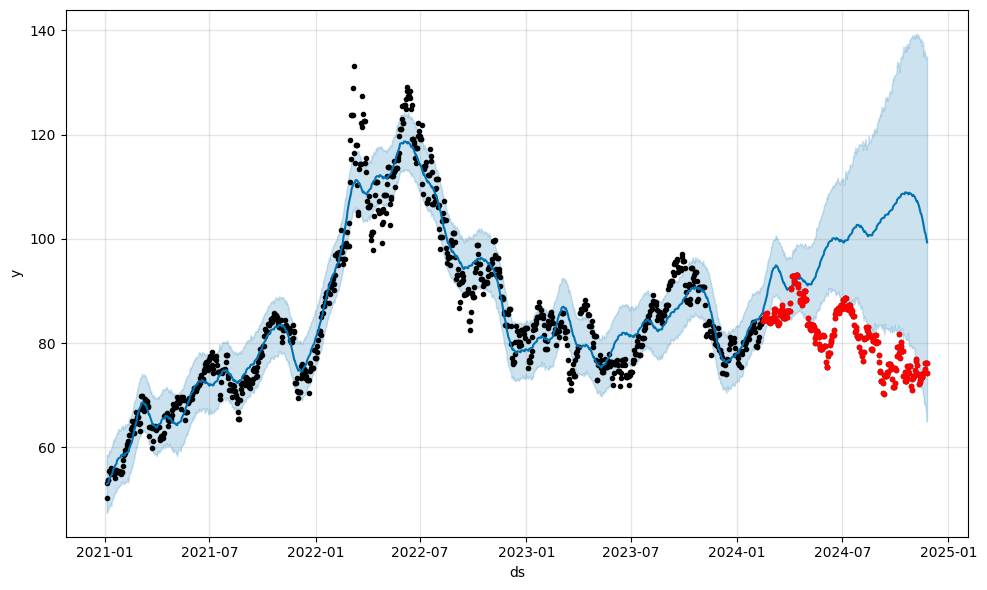

In [135]:
fig1 = modelo.plot(previsao_separado)

plt.plot(teste['ds'], teste['y'], '.r')
plt.show()

##**Obtendo métricas de performance**

In [136]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao2 = previsao_separado[['ds', 'yhat']]
df_comparacao2 = pd.merge(df_previsao2, teste, on='ds', how='inner')
df_comparacao2

,ds,yhat,y
0,2024-02-15,86.109520,84.33
1,2024-02-16,86.820727,84.88
2,2024-02-17,87.173364,84.88
3,2024-02-18,87.577216,84.88
4,2024-02-19,88.026675,85.52
...,...,...,...
280,2024-11-21,101.301018,75.09
281,2024-11-22,101.089137,76.10
282,2024-11-23,100.484149,76.10
283,2024-11-24,99.903114,76.10


In [137]:
# Calculando métricas de erro
mse = mean_squared_error(df_comparacao2['y'], df_comparacao2['yhat']).round(2)
rmse = np.sqrt(mse).round(2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 431.8, RMSE: 20.78


#**Alterando parametros do modelo e avaliando o resultado**

In [ ]:
#Aqui criamos para avaliar a combinação de alguns parametros do modelo e avaliar qual combinação apresenta o melhor resultado

import itertools


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Gerar todas as combinações de parâmetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Armazenar os RMSEs para cada conjunto de parâmetros aqui

# Usar validação cruzada para avaliar todos os parâmetros
for params in all_params:
    m = Prophet(**params).fit(df)  # Ajustar o modelo com os parâmetros fornecidos
    df_cv = cross_validation(m, initial='365.25 days', period='30', horizon = '60 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Encontrar os melhores parâmetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

**Removendo outliers e alterando outros parâmetros**

In [ ]:
#Criando um modelo para usar de referencia
modelo = Prophet()

# Treinar o modelo
modelo.fit(df_prophet)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=0, freq='D')
previsao = modelo.predict(futuro)

14:03:33 - cmdstanpy - INFO - Chain [1] start processing
14:03:33 - cmdstanpy - INFO - Chain [1] done processing


In [169]:
sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower'])&(df_prophet['y'] < previsao['yhat_upper'])]

In [163]:
sem_outliers.reset_index(drop=True, inplace=True)

In [170]:
df_treino_sem_outliers = pd.DataFrame()
df_teste_sem_outliers = pd.DataFrame()

divisao = int(len(sem_outliers) * 0.8)

df_treino_sem_outliers = sem_outliers[:divisao]
df_teste_sem_outliers = sem_outliers[divisao:]

##**Treinando o modelo sem os outliers e alterando alguns parâmetros**

In [175]:
# Instanciar o modelo Prophet
modelo_final = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)

# Treinar o modelo
modelo_final.fit(df_treino_sem_outliers)

# Criar um dataframe para previsões futuras
futuro = modelo_final.make_future_dataframe(periods=int(len(df_teste_sem_outliers)), freq='D')

# Fazer a previsão
previsao = modelo_final.predict(futuro)

14:08:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:41 - cmdstanpy - INFO - Chain [1] done processing


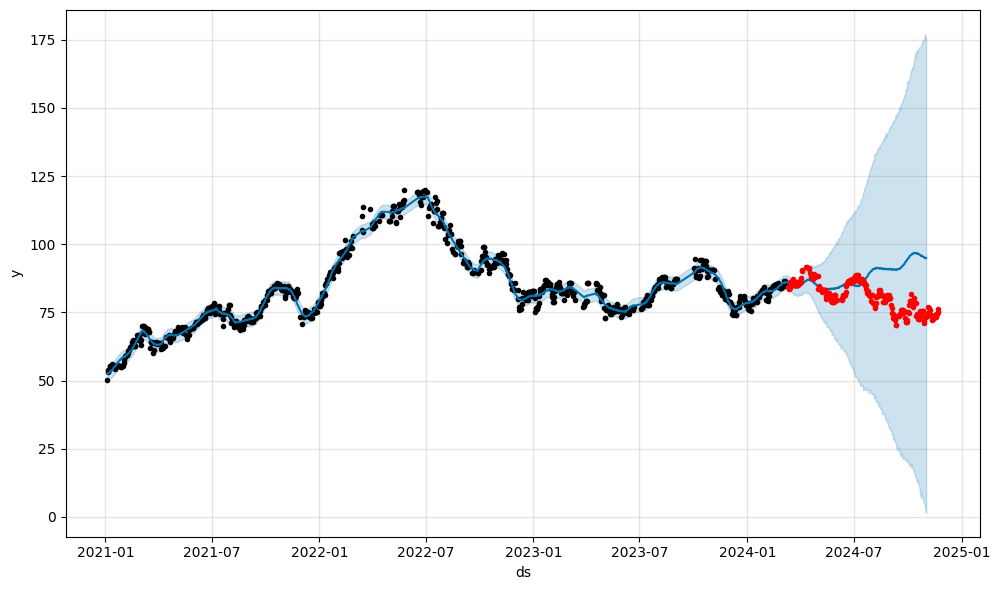

In [176]:
fig1 = modelo_final.plot(previsao)


plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')

In [177]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao_sem_outliers = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao_sem_outliers, teste, on='ds', how='inner')
df_comparacao

,ds,yhat,y
0,2024-02-15,83.016787,84.33
1,2024-02-16,83.310953,84.88
2,2024-02-17,83.286925,84.88
3,2024-02-18,83.316888,84.88
4,2024-02-19,83.612500,85.52
...,...,...,...
256,2024-10-28,95.315268,71.87
257,2024-10-29,95.182611,71.09
258,2024-10-30,94.835890,73.21
259,2024-10-31,94.881726,73.25


In [178]:
# Calculando métricas de erro
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 108.64, RMSE: 10.42


##**Salvando o modelo**

In [179]:
with open('modelo_prophet.json', 'w') as file_out:
    json.dump(model_to_json(modelo_final), file_out)